<a href="https://colab.research.google.com/github/lauraceciliadiazdavila/IA-LIDeSIA-Dpto-Computacion/blob/main/07_Kmeans/2025_2_kmeans_con_pca.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

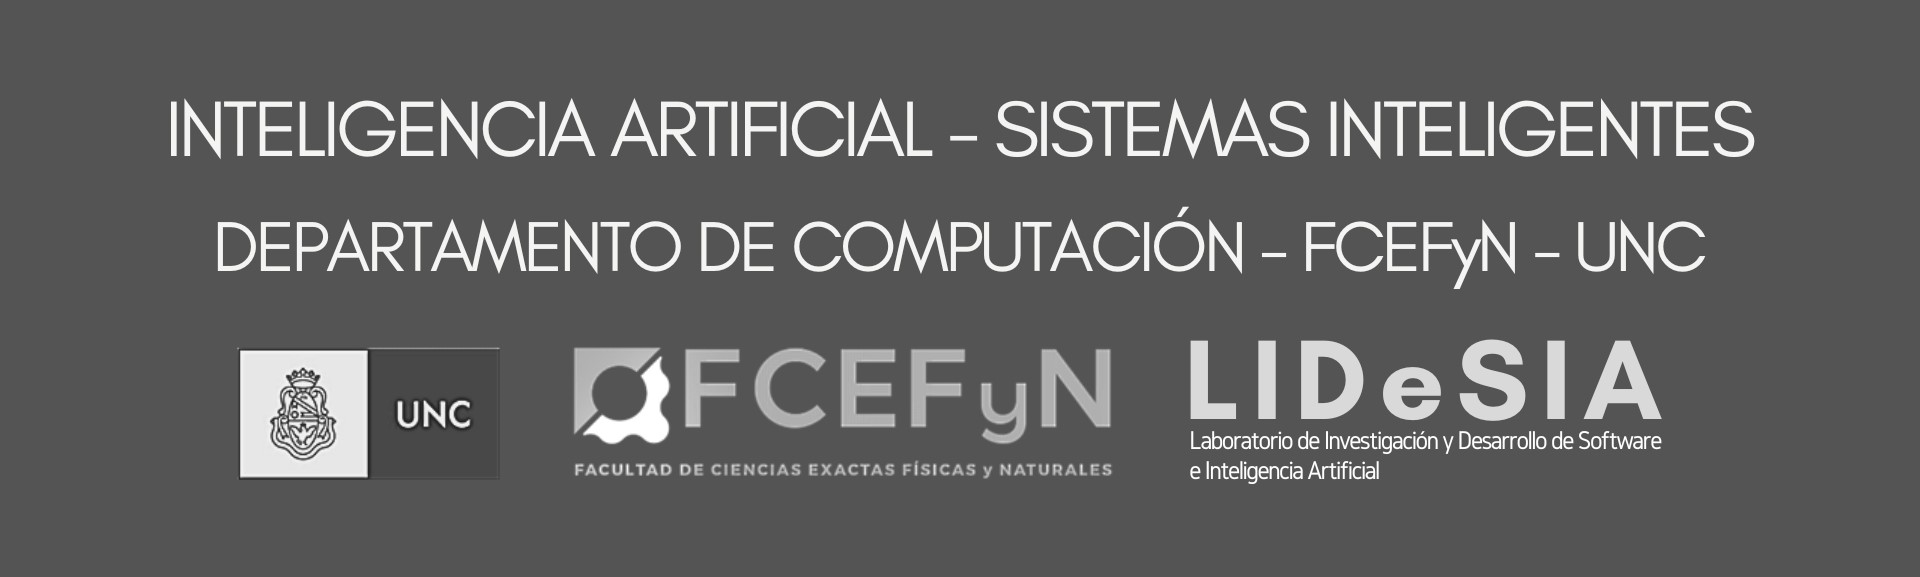

---

FCEFyN - UNC - Cátedra de Inteligencia Artificial - Año 2025


---

*   Autor: Mgtr. Ing. Mauro Furer (FCEFyN)

*   Directora: Dra. Laura Cecilia Diaz Davila (LIDeSIA - FCEFyN)

---

# Segmentación de clientes de un centro comercial

Ete ejemplo utiliza un dataset educativo con datos básicos de clientes de un mall (edad, género, ingresos, gasto). El objetivo es aplicar clustering (K-Means) para segmentar clientes y encontrar grupos relevantes para diseñar estrategias de marketing.

Fuente de datos: https://www.kaggle.com/datasets/vjchoudhary7/customer-segmentation-tutorial-in-python

## Descarga de Dataset desde kaggle

In [1]:
!curl -L -o /content/customer-segmentation.zip  https://www.kaggle.com/api/v1/datasets/download/vjchoudhary7/customer-segmentation-tutorial-in-python\
 && unzip -o /content/customer-segmentation.zip -d /content/customer-segmentation/ \
 && rm -f /content/customer-segmentation.zip


  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
  0     0    0     0    0     0      0      0 --:--:-- --:--:-- --:--:--     0
100  1583  100  1583    0     0   1497      0  0:00:01  0:00:01 --:--:--  1497
Archive:  /content/customer-segmentation.zip
  inflating: /content/customer-segmentation/Mall_Customers.csv  


# Lectura de dataset

In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import plotly.express as px
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.cluster import KMeans
from sklearn.decomposition import PCA

df_base = pd.read_csv("/content/customer-segmentation/Mall_Customers.csv")
df = df_base.copy()

Se muestran algunos registros para explorarlos

In [3]:
df

,CustomerID,Gender,Age,Annual Income (k$),Spending Score (1-100)
0,1,Male,19,15,39
1,2,Male,21,15,81
2,3,Female,20,16,6
3,4,Female,23,16,77
4,5,Female,31,17,40
...,...,...,...,...,...
195,196,Female,35,120,79
196,197,Female,45,126,28
197,198,Male,32,126,74
198,199,Male,32,137,18


## Método del codo para calcular la inercia para distinto número de clusters

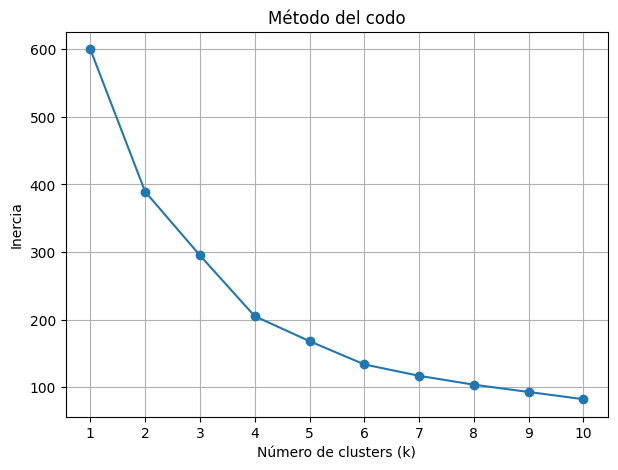

In [4]:
# Definimos cuales son las features
num_cols = ["Age", "Annual Income (k$)", "Spending Score (1-100)"]

# Estandarizamos los valores de las features numéricas
scaler = StandardScaler()
X = scaler.fit_transform(df[num_cols])

# Método del codo: calcular inercia para distintos k
inertia = []
K = range(1, 11)
for k in K:
    km = KMeans(n_clusters=k, random_state=42, n_init=10)
    km.fit(X)
    inertia.append(km.inertia_)

# Grafico de codo
plt.figure(figsize=(7,5))
plt.plot(list(K), inertia, marker="o")
plt.xticks(list(K))
plt.xlabel("Número de clusters (k)")
plt.ylabel("Inercia")
plt.title("Método del codo")
plt.grid(True)
plt.show()


Entrenamos k-means con un criterio basado en el gráfico anterior

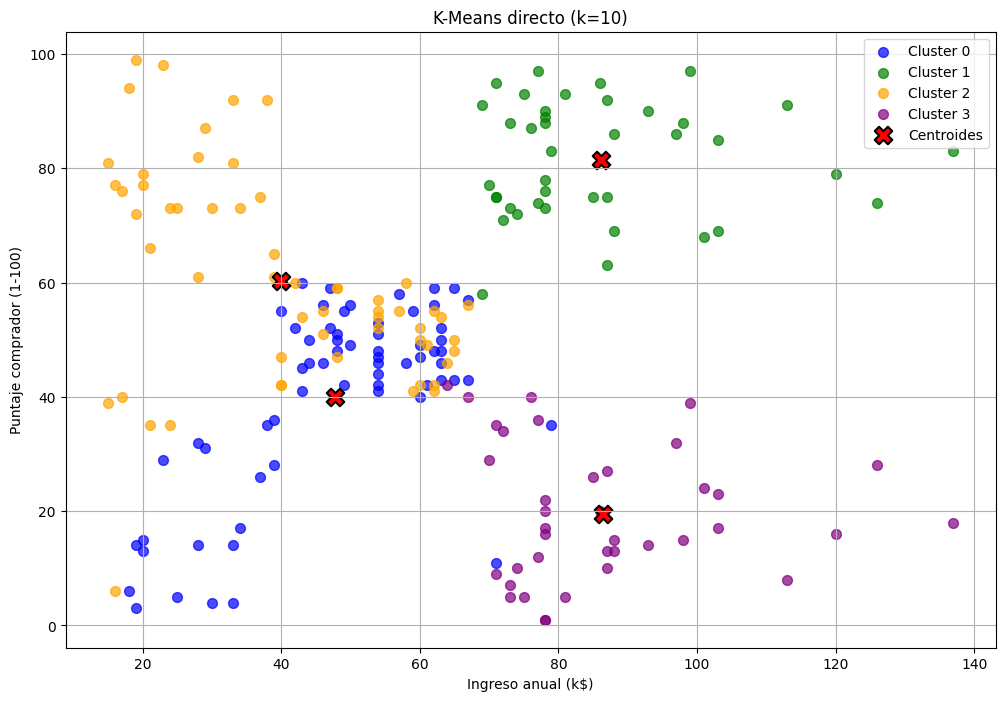



               Age                      Annual Income (k$)                  \
              mean median min max count               mean median min  max   
Cluster                                                                      
0        53.984615   52.0  35  70    65          47.707692   49.0  18   79   
1        32.875000   32.0  27  40    40          86.100000   78.5  69  137   
2        25.438596   24.0  18  38    57          40.000000   40.0  15   67   
3        39.368421   40.5  19  59    38          86.500000   79.5  64  137   

              Spending Score (1-100)                       
        count                   mean median min max count  
Cluster                                                    
0          65              39.969231   46.0   3  60    65  
1          40              81.525000   83.0  58  97    40  
2          57              60.298246   56.0   6  99    57  
3          38              19.578947   17.0   1  42    38  


In [5]:
k_optimo = 4
kmeans = KMeans(n_clusters=k_optimo, random_state=42)
labels = kmeans.fit_predict(X) # obtengo el label para cada observacion

# Pegar etiquetas y perfilar clusters
df["Cluster"] = labels
perfil = df.groupby("Cluster")[num_cols].agg(["mean","median","min","max","count"])

# Recuperamos centroides en escala original
centroids_num = scaler.inverse_transform(kmeans.cluster_centers_)

# Graficamos Ingreso vs Spending con referencias y centroides
plt.figure(figsize=(12,8))

colors = ["blue", "green", "orange", "purple", "red", "yellow", "cyan"]

for cluster in range(k_optimo):
    sub = df[df["Cluster"] == cluster]
    plt.scatter(
        sub["Annual Income (k$)"],
        sub["Spending Score (1-100)"],
        color=colors[cluster],
        s=50, alpha=0.7,
        label=f"Cluster {cluster}"
    )

# centroides: columna 1 = Ingreso, columna 2 = Spending
plt.scatter(
    centroids_num[:, 1],
    centroids_num[:, 2],
    c="red", marker="X", s=160, edgecolors="black", linewidths=1.5,
    label="Centroides"
)

plt.xlabel("Ingreso anual (k$)")
plt.ylabel("Puntaje comprador (1-100)")
plt.title(f"K-Means directo (k={k})")
plt.legend()
plt.grid(True)
plt.show()

print("\n")
print(perfil)


In [6]:
# grafico 3D
fig = px.scatter_3d(df,
                    x="Age",
                    y="Annual Income (k$)",
                    z="Spending Score (1-100)",
                    color="Cluster",
                    symbol="Cluster",
                    size_max=10,
                    opacity=0.7)

fig.update_traces(marker=dict(size=5))

fig.update_layout(
    width=1200, height=800,
    scene=dict(
        xaxis_title="Edad (años)",
        yaxis_title="Ingreso Anual en miles USD",
        zaxis_title="Puntaje comprador (1-100)"
    )
)

fig.update_layout(width=1200, height=800)

fig.show()


# Reducción de la dimensionalidad

## PCA

Varianza explicada total (PCA1+PCA2): 0.7757454566976747


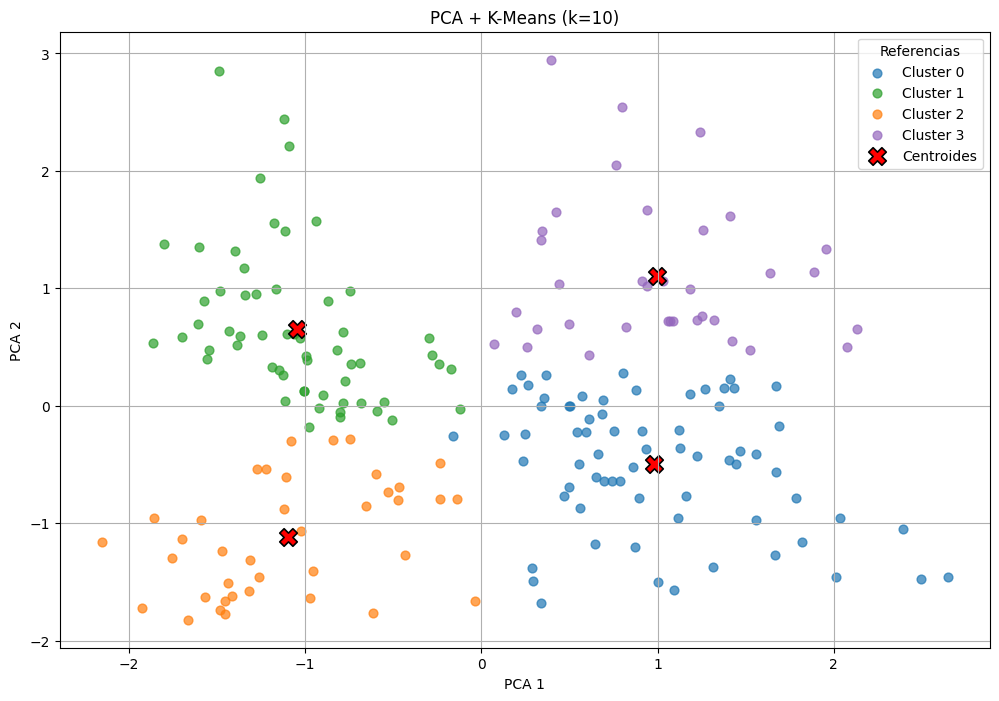

In [7]:
# PCA a 2D
pca = PCA(n_components=2, random_state=42)
X_pca = pca.fit_transform(X)
print("Varianza explicada total (PCA1+PCA2):", pca.explained_variance_ratio_.sum())

# K-Means en el espacio PCA
k_optimo = 4
kmeans = KMeans(n_clusters=k_optimo, random_state=42, n_init=10)
labels = kmeans.fit_predict(X_pca)
centroids = kmeans.cluster_centers_

# Plot
colors = ["tab:blue","tab:green","tab:orange","tab:purple"]
plt.figure(figsize=(12,8))
for c in range(k_optimo):
    mask = labels == c
    plt.scatter(X_pca[mask, 0], X_pca[mask, 1],
                s=40, alpha=0.7, color=colors[c], label=f"Cluster {c}")

# Centroides como cruces
plt.scatter(centroids[:,0], centroids[:,1],
            c="red", marker="X", s=160, edgecolors="black", linewidths=1.2,
            label="Centroides")

plt.xlabel("PCA 1")
plt.ylabel("PCA 2")
plt.title(f"PCA + K-Means (k={k})")
plt.legend(title="Referencias")
plt.grid(True)
plt.show()

# Coeficientes de las componentes principales

Indican el aporte de la variable original a cada componente PCA

In [8]:

loadings = pd.DataFrame(
    pca.components_.T, # Vectores propios del PCA
    columns=["PCA1", "PCA2"],
    index=num_cols
)

print(loadings)


                            PCA1      PCA2
Age                     0.706382  0.030141
Annual Income (k$)     -0.048024  0.998832
Spending Score (1-100) -0.706199 -0.037775
